In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import numpy as np
import os
import sys
import math
import timeit
import pickle
import scipy.io as sio
import scipy.linalg as la
import scipy.sparse as sp
import scipy.interpolate as itpl
import mcm_funci as mcm
import ROSsolver_e as ROS
import NNEITe as NNE

figdir = 'C:\\Users\\Yuanlong\\Documents\\YHUANG\\ML210518\\Plots\\'
options = {
    'solver' : 2,
    'Hmin'   : 0.0e+00,
    'Hmax'   : 1.0e+01,
    'Hstart' : 1.0e-07,
    'Dmin'   : 1.0e-08,
    'FacMin' : 1.0e-01,
    'FacMax' : 1.0e+01,
    'FacSafe': 1.0e+00,
    'FacRej' : 1.0e-01,
    'AbsTol' : 1.0e-14,
    'RelTol' : 1.0e-03,
    'MaxStep': 2.0e+05,
    'eps'    : sys.float_info.epsilon,
}

ODEfcn  = mcm.mcm_dCdt
ODEfcni = mcm.mcm_pdls
ODEjac  = mcm.mcm_Jacob

M = 1 # unit ppm
cvt = [1, 1] # scale


In [2]:
with open('NN_H2O2_4c.pkl', 'rb') as f: # Getting back the objects:
    [hwc1,hwc2] = pickle.load(f)
with open('NN_H2O2_4e.pkl', 'rb') as f: # Getting back the objects:
    [hwt1,hwt2] = pickle.load(f)
hnnwt = {'func':1,
         'wc11':hwc1,'wc12':hwc2,
         'wt11':hwt1,'wt12':hwt2,
         'scale1':6}
options['Hstart'] = 1.0e-08
options['AbsTol'] = 1.0e-14
options['Hmax'] = 47.0
options['eps'] = 1.0e-16
h_nne = NNE.NNEIT(options)
h_ros = ROS.ROSsolver(options)

h_kwargs = {'ks'  : np.array([3.0e-05, 1.7e-12*2.45e13, 3.1e-12*2.45e13, 1.1e-10*2.45e13])*60, # (ppm-1) min-1
            'rmat': np.array([[0,0,1],[0,1,2],[2,0,3],[1,2,2]]),
            'smat': sp.csr_matrix(np.array([[-1,-1,1,0],[2,-1,0,-1],[0,1,-2,-1]])),
            'pmat': sp.csr_matrix(np.array([[0,0,1,0],[2,0,0,0],[0,1,0,0]])),
            'rRO2': [False]*4,
            'iRO2': [False]*3,
            'M'   : M,
            'cvt' : cvt,
           } # **mcm_kwargs for call
hspecies = ['H2O2','OH','HO2']
hspec = ['H$_2$O$_2$','OH','HO$_2$'] # species for plot legend
hinit_C = {'H2O2':1.0,'OH':0,'HO2':0
          } # ppm
hC0 = mcm.mcm_init(hinit_C,hspecies,cvt) # ppm
hRT = 1e3 # min

tic = timeit.default_timer()
hsol_1 = h_ros(ODEfcn, [0,hRT],hC0,ODEjac,h_kwargs)
toc = timeit.default_timer()
print(toc-tic)
tic = timeit.default_timer()
hsol_2 = h_nne(ODEfcni,[0,hRT],hC0,h_kwargs,hnnwt)
toc = timeit.default_timer()
print(toc-tic)
print(hsol_1.ISTAT)
print(hsol_2.t.shape)

0.06238859999999935
0.0053176000000005885
{'Nfun': 118, 'Njac': 59, 'Nstp': 59, 'Nacc': 59, 'Nrej': 0, 'Ninv': 177}
(44,)


<ipython-input-3-e5dd5ea38961>:12: RuntimeWarning: invalid value encountered in true_divide
  relerr = (itpl.interp1d(hsol_2.t,hsol_2.y[i])(hsol_1.t)/hsol_1.y[i]-1)*100
<ipython-input-3-e5dd5ea38961>:12: RuntimeWarning: invalid value encountered in true_divide
  relerr = (itpl.interp1d(hsol_2.t,hsol_2.y[i])(hsol_1.t)/hsol_1.y[i]-1)*100


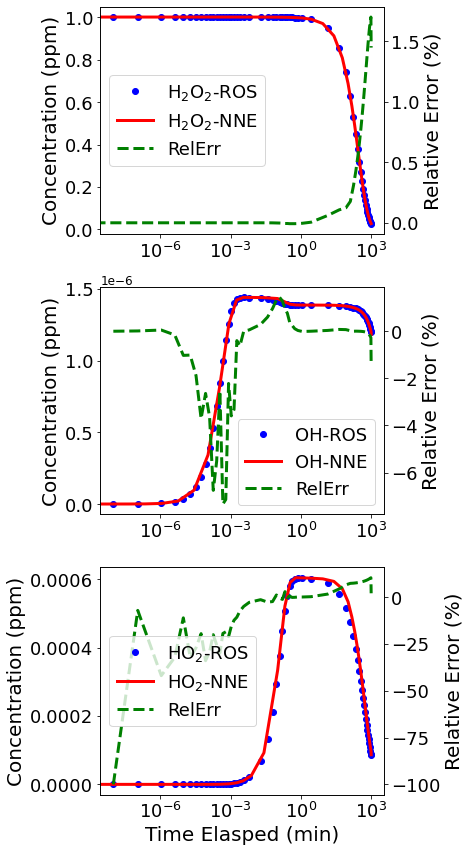

In [3]:
s = len(hspec)
fig = plt.figure(figsize=(6.7, 12))
lloc = ['center left','lower right','center left']
for i in np.arange(s):
    ax1 = fig.add_subplot(s,1,i+1)
    l1, = ax1.semilogx(hsol_1.t,hsol_1.y[i],'bo')
    l2, = ax1.semilogx(hsol_2.t,hsol_2.y[i],'r-',linewidth=3)
    ax1.tick_params(labelsize=18)
    if i==2: plt.xlabel('Time Elasped (min)',fontsize=20)
    plt.ylabel('Concentration (ppm)',fontsize=20)
    
    relerr = (itpl.interp1d(hsol_2.t,hsol_2.y[i])(hsol_1.t)/hsol_1.y[i]-1)*100
    ax2 = ax1.twinx()
    l3, = ax2.semilogx(hsol_1.t,relerr,'g--',linewidth=3)
    ax2.tick_params(labelsize=18)
    plt.ylabel('Relative Error (%)',fontsize=20)
    plt.legend((l1,l2,l3),(hspec[i]+'-ROS',hspec[i]+'-NNE','RelErr'),loc=lloc[i],fontsize=18)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'H2O2_ROS_NNE_conc.png',dpi=300)

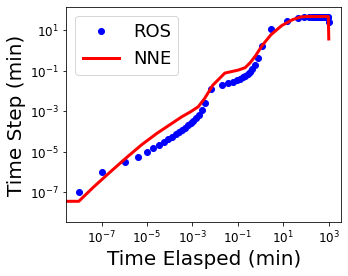

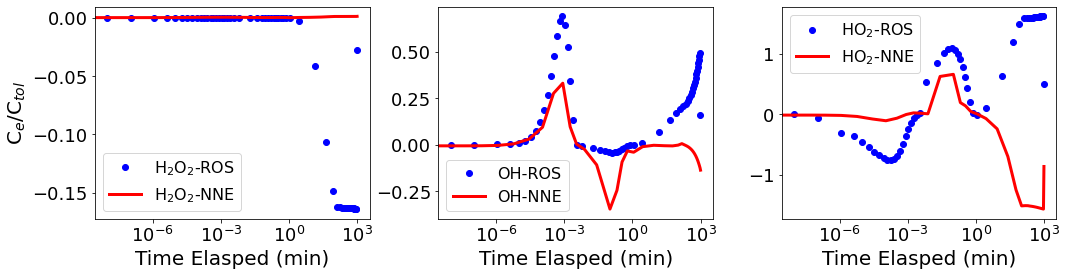

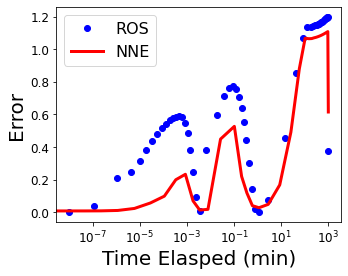

In [4]:
fig = plt.figure(figsize=(5, 4))
plt.loglog(hsol_1.t[:-1],np.diff(hsol_1.t),'bo',label='ROS')
plt.loglog(hsol_2.t[:-1],np.diff(hsol_2.t),'r-',label='NNE',linewidth=3)
plt.xlabel('Time Elasped (min)',fontsize=20)
plt.ylabel('Time Step (min)',fontsize=20)
plt.legend(fontsize=18)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'H2O2_ROS_NNE_dt.png',dpi=300)

s = len(hspec)
fig = plt.figure(figsize=(15, 4))
for i in range(s):
    ax = fig.add_subplot(1,s,i+1)
    ax.semilogx(hsol_1.t[:-1],hsol_1.e[i],'bo',label=hspec[i]+'-ROS')
    ax.semilogx(hsol_2.t[:-1],hsol_2.e[i],'r-',label=hspec[i]+'-NNE',linewidth=3)
    ax.tick_params(labelsize=18)
    plt.xlabel('Time Elasped (min)',fontsize=20)
    if i==0: plt.ylabel('C$_e$/C$_{tol}$',fontsize=20)
    plt.legend(fontsize=16)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'H2O2_ROS_NNE_relerr.png',dpi=300)

fig = plt.figure(figsize=(5, 4))
he1 = (np.sum(hsol_1.e**2,0)/2)**0.5
he2 = (np.sum(hsol_2.e**2,0)/2)**0.5
plt.semilogx(hsol_1.t[:-1],he1,'bo',label='ROS')
plt.semilogx(hsol_2.t[:-1],he2,'r-',label='NNE',linewidth=3)
ax.tick_params(labelsize=18)
plt.xlabel('Time Elasped (min)',fontsize=20)
plt.ylabel('Error',fontsize=20)
plt.legend(fontsize=16)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'H2O2_ROS_NNE_err.png',dpi=300)

In [5]:
with open('NN_Verwer_a.pkl', 'rb') as f: # Getting back the objects:
    [_,pwc12] = pickle.load(f)
with open('NN_Verwer_ae.pkl', 'rb') as f: # Getting back the objects:
    [pwt11,pwt12,ps1] = pickle.load(f)
with open('NN_Verwer_b.pkl', 'rb') as f: # Getting back the objects:
    [pwc21,pwc22] = pickle.load(f)
with open('NN_Verwer_be.pkl', 'rb') as f: # Getting back the objects:
    [pwt21,pwt22,ps2] = pickle.load(f)
with open('NN_Verwer_c.pkl', 'rb') as f: # Getting back the objects:
    [pwc31,pwc32] = pickle.load(f)
with open('NN_Verwer_ce.pkl', 'rb') as f: # Getting back the objects:
    [pwt31,pwt32,ps3] = pickle.load(f)
with open('NN_Verwer_d.pkl', 'rb') as f: # Getting back the objects:
    [pwc41,pwc42] = pickle.load(f)
with open('NN_Verwer_de.pkl', 'rb') as f: # Getting back the objects:
    [pwt41,pwt42,ps4] = pickle.load(f)
with open('NN_Verwer_e.pkl', 'rb') as f: # Getting back the objects:
    [pwc51,pwc52] = pickle.load(f)
with open('NN_Verwer_ee.pkl', 'rb') as f: # Getting back the objects:
    [pwt51,pwt52,ps5] = pickle.load(f)
pnnwt = {'func':2,
         'wc11':[],   'wc12':pwc12,
         'wc21':pwc21,'wc22':pwc22,
         'wc31':pwc31,'wc32':pwc32,
         'wc41':pwc41,'wc42':pwc42,
         'wc51':pwc51,'wc52':pwc52,
         'wt11':pwt11,'wt12':pwt12,
         'wt21':pwt21,'wt22':pwt22,
         'wt31':pwt31,'wt32':pwt32,
         'wt41':pwt41,'wt42':pwt42,
         'wt51':pwt51,'wt52':pwt52,
         'scale1':ps1/5,'scale2':ps2/5,'scale3':ps3/10,
         'scale4':ps4/50.8,'scale5':ps5/20,
         'r1':1.0e-5,'r2':1.0e-4,'r3':7.0e-3,'r4':1.0,
         }
options['Hstart'] = 1.0e-19
options['AbsTol'] = 1.0e-25
options['eps'] = 1.0e-22
options['Hmax'] = 5
p_nne = NNE.NNEIT(options)
p_ros = ROS.ROSsolver(options)

with open('Verwer.pkl', 'rb') as f: # Getting back the objects:
    pspecies,ks,rmat,pmat,smat,rRO2,iRO2 = pickle.load(f)
p_kwargs = {'ks'  : ks,
            'rmat': rmat,
            'pmat': pmat,
            'smat': smat,
            'rRO2': rRO2,
            'iRO2': iRO2,
            'M'   : M,
            'cvt' : cvt,
           } # **mcm_kwargs for call
pspec = ['ALD', 'C$_2$O$_3$', 'CH$_3$O', 'CH$_3$O$_2$', 'CO', 
         'CO$_2$', 'HCHO', 'HNO$_3$', 'HO$_2$', 'N$_2$O$_5$', 
         'NO', 'NO$_2$', 'NO$_3$', 'O$^{1D}$', 'O$_3$',
         'O$^{3P}$', 'OH', 'PAN', 'SO$_2$', 'SO$_4$'
        ] # species for plot legend
pinit_C = {'NO'  : 0.200,
           'O3'  : 0.040,
           'HCHO': 0.100,
           'CO'  : 0.300,
           'ALD' : 0.010,
           'SO2' : 0.007,
          } # ppm
pC0 = mcm.mcm_init(pinit_C,pspecies,cvt) # ppm
pRT = 12 # min

tic = timeit.default_timer()
psol_1 = p_ros(ODEfcn, [0,pRT],pC0,ODEjac,p_kwargs)
toc = timeit.default_timer()
print(toc-tic)
tic = timeit.default_timer()
psol_2 = p_nne(ODEfcni,[0,pRT],pC0,p_kwargs,pnnwt)
toc = timeit.default_timer()
print(toc-tic)
print(psol_1.ISTAT)
print(psol_2.t.shape)

0.17160709999999924
0.017984200000000783
{'Nfun': 288, 'Njac': 144, 'Nstp': 144, 'Nacc': 144, 'Nrej': 0, 'Ninv': 432}
(144,)


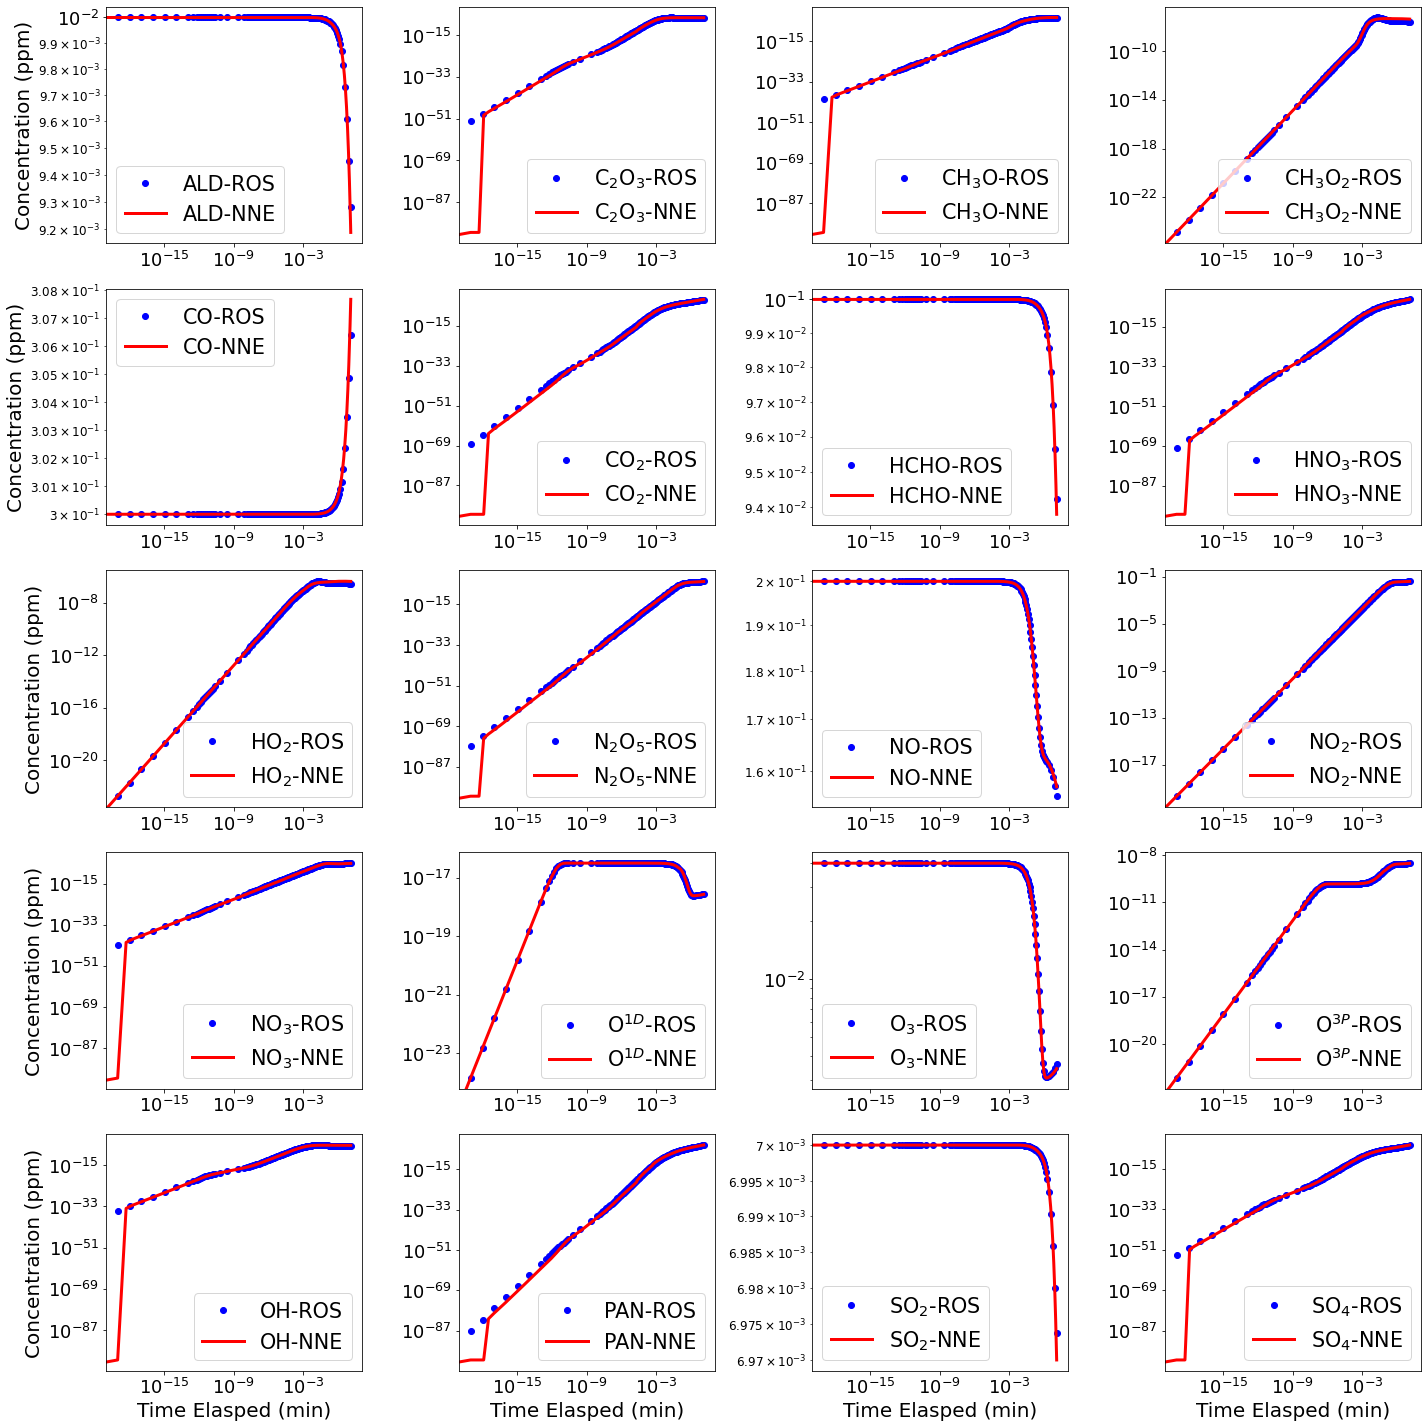

In [6]:
s = len(pspec)
nrows,ncols = 5,4
fig = plt.figure(figsize=(20, 20))
for i in np.arange(s):
    ax1 = fig.add_subplot(nrows,ncols,i+1)
    l1, = ax1.loglog(psol_1.t,psol_1.y[i],'bo')
    l2, = ax1.loglog(psol_2.t,psol_2.y[i],'r-',linewidth=3)
    if i>15: plt.xlabel('Time Elasped (min)',fontsize=20)
    if np.mod(i,4)==0: plt.ylabel('Concentration (ppm)',fontsize=20)
    plt.legend((l1,l2),(pspec[i]+'-ROS',pspec[i]+'-NNE'),fontsize='xx-large')
    ax1.tick_params(labelsize=18)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_ROS_NNE_conc.png',dpi=300)

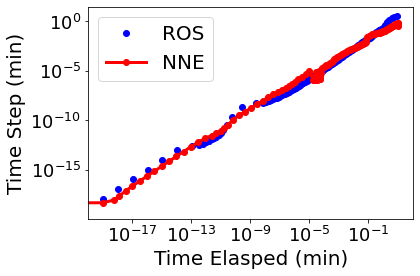

In [7]:
fig = plt.figure(figsize=(6, 4))
plt.loglog(psol_1.t[:-1],np.diff(psol_1.t),'bo',label='ROS')
plt.loglog(psol_2.t[:-1],np.diff(psol_2.t),'ro-',label='NNE',linewidth=3)
# plt.plot(psol_1.t[:-1],np.diff(psol_1.t),'bo',label='ROS')
# plt.plot(psol_2.t[:-1],np.diff(psol_2.t),'rs',label='NNE',linewidth=3)
plt.xlabel('Time Elasped (min)',fontsize=20)
plt.ylabel('Time Step (min)',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(fontsize=20)
fig.tight_layout()
plt.show()
# fig.savefig(figdir+'Verwer_ROS_NNE_dt.png',dpi=300)